# FRB Project

This is the main file from which we run all the different parts of the project. 

The basic algorithm is as follows:

- First we run the following chapters:
    - Chapter 1 sets the parameters for the method. The cosmological parameters are set here, as well as the particular parameters for the simulation in use.
    - Chapter 2 and 3 extract the density field and the halo tables from the downloaded csv files from the simulation website. The files must be named as described in the chapter to ensure that reading them in is automated.
    - Chapter 4 contains the methods to remove and add halos from the density field using different profiles chosen by the user. If the profile is more specialized like FIRE or Precipitation, a separate python file is created with these profile which is called by "add_halos" method.
    - Chapter 5 takes the final density field of the halos after they have been added back using a prescribed profile, and trims the halos to create an impact parameter plot.
    - Chapter 6 stacks multiple boxes based on the redshift to which we want to evaluate the dispersion measure.


- Then we set the specifications as given in the "Specifications" box below, and create a halo field for the chosen resolution and profile from the many choices in "profiles". This applies the functions from the chapters 1-6 and gives a final density field with the given choice of halo profile.
- Impact parameter plots: from the final field we create plots for impact parameter for single simulation box
- Redshift stacking: we take the final field and stack it on top of each other to calculate the dispersion measure out to a given redshift.

In [1]:
# imports packages
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
#import csv
import random
import scipy.integrate as integrate
from numpy import genfromtxt
from random import randrange
from numpy.polynomial import Polynomial as P
from IPython.display import Latex
import time
from decimal import Decimal
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Since we are not working with 512 grid all that much it's okay to skip Chapt 512 grid

# This chapter contains contains all cosmological parameters, as well as other basic functions 
%run FRBProject-Chap1-ParametersAndFunctions.ipynb

# These chapters extracts data from simulation files 
%run FRBProject-Chap2-ExtractData-256Grid.ipynb
%run FRBProject-Chap3-ExtractData-Halos.ipynb
#%run FRBProject-Chap2-ExtractData-512Grid.ipynb


# This chapter is the core of the method developed in this project
%run FRBProject-Chap4-Convolution.ipynb


# This chapter contains functions for creating dispersion measure profiles of halos
%run FRBProject-Chap5-DMProfiles.ipynb


# This chapter contains functions to stack boxes to project a sightline to higher redshifts
%run FRBProject-Chap6-Stacking.ipynb

In [3]:
varFolder = "../var"

# Intermediate numpy arrays get can be saved into var folder outside version control
def saveArray(filename, array):
    file_path = os.path.join(varFolder, filename)
    
    if not(os.path.exists(varFolder)):
        os.makedirs(varFolder)

    np.save(file_path, array)
    
def loadArray(filename):
    file_path = os.path.join(varFolder, filename)
    return np.load(file_path, allow_pickle=True)


# The following chapters must be executed first:

# 1: Method applied to a single box

### Specifications

In [4]:
# Resolution: choose between 256 and 512 grid
den_grid_size = 256



# User provides a redshift array
RS_array = [0] # For a single box, we only use the redshift 0 box



# Profile used for subtracting halos from the density field
subtraction_halo_profile = 'NFW'


# Mass range of halos
min_mass=10**10
max_mass=10**14.5
log_bins=30


In [5]:
# Create density field for the chosen resolution

# all_den_fields_512 = extract_all_den_fields(RS_array,den_grid_size)
all_den_fields_256 = extract_all_den_fields(RS_array,den_grid_size)

## 1.1 Profiles

The user can choose from a range of profiles: 'NFW', 'tophat_spherical', 'fire', or make their own custom profile

Outputs of the hist_profile function are: histogram of stacked field,halos-readded field, halo addition masks, halos removed coarse, halo addition field, halos removed field, stacked halo field, virial_radii of halos

#### Tophat 512 field

In [11]:
# addition profile

addition_halo_profile = 'tophat_spherical'
scaling_radius = 1



# STH1_512 = hist_profile(all_den_fields,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,1)


# STH2_512 = hist_profile(all_den_fields,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,2)


# STH4_512 = hist_profile(all_den_fields,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,4)


# STH8_512 = hist_profile(all_den_fields,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,8)




#### Tophat 256 field, scaling radius 1

In [6]:
### Tophat 256 fieild


addition_halo_profile = 'tophat_spherical'
scaling_radius = 1 

# Resolution: 1*1024

STH1_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)


# STH2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,2)


# STH4_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,4)


# STH8_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,8)


# STH16_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,16)

# saveArray('STH16_256',STH16_256)



# STH32_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,32)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


#### Tophat 256 field, scaling radius 2

In [ ]:


addition_halo_profile = 'tophat_spherical'
scaling_radius = 2 

# STH1_2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)


# STH2_2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,2)


# STH4_2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,4)


STH8_2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,8)


# STH16_2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,16)


#### NFW

In [ ]:
# addition profile
scaling_radius = 1
addition_halo_profile = 'NFW'


# NFW1_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)

# NFW2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,2)

# NFW4_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,4)


# NFW8_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,8)


NFW16_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,16)

saveArray('NFW16_256',NFW16_256)

#### Fire

In [ ]:
# addition profile
scaling_radius = 1
addition_halo_profile = 'fire'

# fire1_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)


# fire2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,2)


# fire4_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,4)


# fire8_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,8)

# saveArray('fire8_256',fire8_256)


# fire16_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,16)

# saveArray('fire16_256',fire16_256)


# fire32_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,32)

#### Precipitation

In [ ]:



addition_halo_profile = 'precipitation'
scaling_radius = 1 

# P1_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)


# P2_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,2)


# P4_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,4)


# P8_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,8)


P16_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,16)

saveArray('P16_256',P16_256)

# P32_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,32)


## 1.2 Save all arrays generated above


In [7]:
# All density files
saveArray('all_den_fields_256',all_den_fields_256)
# saveArray('all_den_fields_512',all_den_fields)

In [9]:
## Save Spherical tophat profiles

# BUG saving with np.array expects a numpty array but the hist_profile method returns a tuple with a bunch of np arrays
#     Could use pickle.dump(array,open("file","w"))
saveArray('STH1_256',STH1_256[1])
# saveArray('STH2_256',STH2_256)
# saveArray('STH4_256',STH4_256)
# saveArray('STH8_256',STH8_256)
# saveArray('STH16_256',STH16_256)


## Load profiles if not on file

#STH1_256 = loadArray('STH1_256.npy')
# STH2_256 = loadArray('STH2_256.npy')
# STH4_256 = loadArray('STH4_256.npy')
# STH8_256 = loadArray('STH8_256.npy')
# STH16_256 = loadArray('STH16_256.npy')



# saveArray('STH1_512',STH1_512)
# saveArray('STH2_512',STH2_512)
# saveArray('STH4_512',STH4_512)
# saveArray('STH8_512',STH8_512)


(1, array([[[ 78.06485453,  79.80382355,  79.20223595, ...,  64.51949603,
          74.35889482,  76.09786384],
        [ 74.35889482,  84.92699185, 100.37437219, ...,  59.92537224,
          74.35889482,  82.03270063],
        [126.98016784, 131.95962359, 120.45216988, ...,  88.73270022,
         108.107339  , 110.14728028],
        ...,
        [156.42719637,  72.14749889,  50.10773439, ...,  42.26087174,
          58.30991278,  48.89414948],
        [113.25290151,  83.10034545,  90.41929523, ...,  64.15859915,
          79.65714102,  78.16550395],
        [ 78.58698838,  78.16550395,  86.27497112, ...,  61.56369184,
          74.35889482,  85.58983291]]]), array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0

In [ ]:
# #Tophat profile with scaling radius = 2

# saveArray('STH1_2_256',STH1_2_256)
# saveArray('STH2_2_256',STH2_2_256)
# saveArray('STH4_2_256',STH4_2_256)
# saveArray('STH8_2_256',STH8_2_256)
# saveArray('STH16_2_256',STH16_2_256)



# Load files

STH8_2_256 = loadArray('STH8_2_256.npy')

In [ ]:
# #Save NFW profiles

# saveArray('NFW1_256',NFW1_256)
# saveArray('NFW2_256',NFW2_256)
# saveArray('NFW4_256',NFW4_256)
# saveArray('NFW8_256',NFW8_256)
# saveArray('NFW16_256',NFW16_256)


## Load profiles if not on file
NFW8_256 = loadArray('NFW8_256.npy')
# NFW16_256 = loadArray('NFW16_256.npy')



# saveArray('NFW1_512',NFW1_512)
# saveArray('NFW2_512',NFW2_512)
# saveArray('NFW4_512',NFW4_512)
# saveArray('NFW8_512',NFW8_512)


In [ ]:
# Save fire profiles

# saveArray('fire1_256',fire1_256)
# saveArray('fire2_256',fire2_256)
# saveArray('fire4_256',fire4_256)
# saveArray('fire8_256',fire8_256)
# saveArray('fire16_256',fire16_256)


# load arrays if not on file

# fire1_256 = loadArray('fire1_256.npy')
# fire2_256 = loadArray('fire2_256.npy')
# fire4_256 = loadArray('fire4_256.npy')
fire8_256 = loadArray('fire8_256.npy')
# fire16_256 = loadArray('fire16_256.npy')


In [ ]:
# saveArray('P1_256',P1_256)
# saveArray('P2_256',P2_256)
# saveArray('P4_256',P4_256)
# saveArray('P8_256',P8_256)
# saveArray('P16_256',P16_256)


## Load profiles if not on file

# P1_256 = loadArray('P1_256.npy')
# P2_256 = loadArray('P2_256.npy')
# P4_256 = loadArray('P4_256.npy')
P8_256 = loadArray('P8_256.npy')
# P16_256 = loadArray('P16_256.npy')

## 1.3: Testing output files

The output files can be viewed by creating image plots of the density field

TypeError: Invalid dimensions for image data

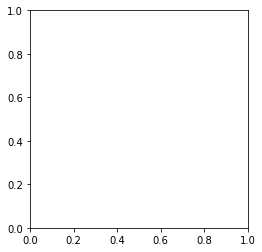

In [9]:
plt.imshow(STH1_256[1])

# 2. Impact parameter: Profiles of halos for DM vs Radius plot


#### Specifications for DM-radius plots

In [ ]:
# This function orders the halo array in ascending mass
# Outputs: ordered dataframe of halos, mass bins

df= create_halo_array_for_convolution(extract_halos(0),min_mass,max_mass,log_bins)
# saveArray('df',df)
# df_halos = loadArray('df.npy')

# Mean DM of single box
mean_DM=np.mean(orig_den_256)

# Configuration for plots
# Masses chosen from the array of 30 log bins
M1=1
M2=8
M3=15
M4=22
M5=28
M_chosen = [M1, M2, M3, M4, M5]




In [ ]:
# Table of virial radii

# vir_rad_ar = STH8_256[7]
# saveArray('vir_rad_ar',vir_rad_ar)
vir_rad_ar = loadArray('vir_rad_ar.npy')

#### Fiducial Resolution: 8 * 1024

In [ ]:
# Specify resolution
resolution=8
grid_size = resolution*1024
trim_dim=int((10*resolution))

# Radial extent of the plots in Mpc
extent = (L/grid_size)*(trim_dim)



### Spherical tophat

In [ ]:
STH_DMvsR_1=DM_vs_radius(STH8_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
saveArray('STH_DMvsR_prof',STH_DMvsR_1[0])


# STH16_DMvsR=DM_vs_radius(STH16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
# saveArray('STH16_DMvsR_prof',STH16_DMvsR[0])

### Spherical tophat, scaling radius: 2

In [ ]:
STH8_2_DMvsR_1=DM_vs_radius(STH8_2_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
saveArray('STH8_2_DMvsR_prof',STH8_2_DMvsR_1[0])


### Fire

In [ ]:
# fire simulation
fire8_DMvsR_1=DM_vs_radius(fire8_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
saveArray('fire8_DMvsR_prof',fire8_DMvsR_1[0])


# fire16_DMvsR=DM_vs_radius(fire16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
# saveArray('fire16_DMvsR_prof',fire16_DMvsR[0])

### NFW

In [ ]:
# NFW

NFW_DMvsR_1=DM_vs_radius(NFW8_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
saveArray('NFW_DMvsR_prof',NFW_DMvsR_1[0])


# NFW16_DMvsR=DM_vs_radius(NFW16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
# saveArray('NFW16_DMvsR_prof',NFW16_DMvsR[0])



### Precipitation

In [ ]:
P_DMvsR_1=DM_vs_radius(P8_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
saveArray('P_DMvsR_prof',P_DMvsR_1[0])


# P16_DMvsR=DM_vs_radius(P16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
# saveArray('P16_DMvsR_prof',P16_DMvsR[0])

### Mask profiles

In [ ]:
# Create profiles of masks


# STH8_masks_1=profile_of_masks(STH8_256[2][0,:,40:120,40:120])
# STH8_2_masks_1 = profile_of_masks(STH8_2_256[2][0,:,40:120,40:120])
# NFW8_masks_1=profile_of_masks(NFW8_256[2][0,:,40:120,40:120])
# fire8_masks_1=profile_of_masks(fire8_256[2][0,:,40:120,40:120])
# P8_masks_1=profile_of_masks(P8_256[2][0,:,40:120,40:120])



# saveArray('STH_masks',STH8_masks_1)
# saveArray('STH_2_masks',STH8_2_masks_1)
# saveArray('NFW_masks',NFW8_masks_1)
# saveArray('fire8_masks_1',fire8_masks_1)
# saveArray('P_masks',P8_masks_1)


### Load saved files

In [ ]:
# Save DM vs Radius profiles

# saveArray('ordered_halo_dataframe',df)



# Load files

STH8_DMvsR = loadArray('STH_DMvsR_prof.npy')
STH8_2_DMvsR = loadArray('STH8_2_DMvsR_prof.npy')
NFW8_DMvsR = loadArray('NFW_DMvsR_prof.npy')
fire8_DMvsR = loadArray('fire8_DMvsR_prof.npy')
P8_DMvsR = loadArray('P_DMvsR_prof.npy')


STH8_masks = loadArray('STH_masks.npy')
NFW8_masks = loadArray('NFW_masks.npy')
fire8_masks = loadArray('fire8_masks_1.npy')
STH8_2_masks = loadArray('STH8_2_masks.npy')
P8_masks = loadArray('P_masks.npy')

### DM vs radius plots

In [ ]:
# figure and subplots


MpctoKpc =1000
x_start=40  #kpc: min impact parameter 


DM_Rad_fig, DM_Rad_axs = plt.subplots(3, 1,
                        gridspec_kw={'hspace': 0.01, 'wspace': .2},figsize=(20,30))

-
# plt.rc('axes', titlesize=30)     # fontsize of the axes title
# plt.rc('axes', labelsize=20)    # fontsize of the x and y labels



# First plot

# DM_Rad_axs[0].semilogx(np.linspace(0,extent,TH_DMvsR.shape[1]),TH_DMvsR[M_chosen[0],:]-mean_DM,'-', label= '2D tophat')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH8_DMvsR.shape[1]),STH8_DMvsR[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat',lw=4,color= 'red')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_DMvsR.shape[1]),STH8_2_DMvsR[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat 2$R_{vir}$',lw=4,color= 'orange')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire8_DMvsR.shape[1]),fire8_DMvsR[M_chosen[1],:]-mean_DM,'-', label= 'fire',lw=4,color='green')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_DMvsR.shape[1]),NFW8_DMvsR[M_chosen[1],:]-mean_DM,'-' ,label= 'NFW',lw=4,color='blue')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,P8_DMvsR.shape[1]),P8_DMvsR[M_chosen[1],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')


# Masks
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH8_masks.shape[1]),STH8_masks[M_chosen[1],:],'--', lw=2,color='red')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_masks.shape[1]),STH8_2_masks[M_chosen[1],:],'--', lw=2,color='orange')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire8_masks.shape[1]),fire8_masks[M_chosen[1],:],'--',lw=2,color='green')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_masks.shape[1]),NFW8_masks[M_chosen[1],:],'--', lw=2,color='blue')


DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,P8_masks.shape[1]),P8_masks[M_chosen[1],:],'--', lw=2,color='c')




# axis title
# DM_Rad_axs[0].set_title('Mass = %.1E' % Decimal(df[2][M_chosen[1]]),fontsize=14)


# Second plot


DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH8_DMvsR.shape[1]),STH8_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=4,color='red')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_DMvsR.shape[1]),STH8_2_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=4,color='orange')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire8_DMvsR.shape[1]),fire8_DMvsR[M_chosen[2],:]-mean_DM,'-' ,label= 'fire',lw=4,color='green')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_DMvsR.shape[1]),NFW8_DMvsR[M_chosen[2],:]-mean_DM,'-', label= 'NFW',lw=4,color='blue')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,P8_DMvsR.shape[1]),P8_DMvsR[M_chosen[2],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')


# Masks
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH8_masks.shape[1]),STH8_masks[M_chosen[2],:],'--', lw=1.5,color='red')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_masks.shape[1]),STH8_2_masks[M_chosen[2],:],'--', lw=1.5,color='orange')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire8_masks.shape[1]),fire8_masks[M_chosen[2],:],'--',lw=1.5,color='green')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_masks.shape[1]),NFW8_masks[M_chosen[2],:],'--', lw=1.5,color='blue')

DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,P8_masks.shape[1]),P8_masks[M_chosen[2],:],'--', lw=2,color='c')




# Error bar
# STH
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_STH,ls='--',drawstyle='steps',color='red',lw=.5)
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_STH2,ls='--',drawstyle='steps',color='orange',lw=.5)
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_fire,ls='--',drawstyle='steps',color='green',lw=.5)
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_NFW,ls='--',drawstyle='steps',color='blue',lw=.5)




# DM_Rad_axs[1].set_title('Mass = %.1E' % Decimal(df[2][M_chosen[2]]),fontsize=14)




# Third plot


DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH8_DMvsR.shape[1]),STH8_DMvsR[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=4,color='red')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_DMvsR.shape[1]),STH8_2_DMvsR[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=4,color='orange')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire8_DMvsR.shape[1]),fire8_DMvsR[M_chosen[3],:]-mean_DM,'-', label= 'Fire',lw=4,color='green')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_DMvsR.shape[1]),NFW8_DMvsR[M_chosen[3],:]-mean_DM, '-',label= 'NFW',lw=4,color='blue')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,P8_DMvsR.shape[1]),P8_DMvsR[M_chosen[3],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')

DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH8_masks.shape[1]),STH8_masks[M_chosen[3],:],'--', lw=2,color='red')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_masks.shape[1]),STH8_2_masks[M_chosen[3],:],'--', lw=2,color='orange')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire8_masks.shape[1]),fire8_masks[M_chosen[3],:],'--',lw=2,color='green')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_masks.shape[1]),NFW8_masks[M_chosen[3],:], '--',lw=2,color='blue')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,P8_masks.shape[1]),P8_masks[M_chosen[3],:],'--', lw=2,color='c')



# DM_Rad_axs[2].set_title('Mass = %.1E' % Decimal(df[2][M_chosen[3]]),fontsize=14)




# ticks

# ax.xaxis.grid(True, which='minor')
# DM_Rad_axs[0].xaxis.grid(axis='x', which='minor', bottom=True)

# DM_Rad_axs[0].tick_params(axis='x', which='minor', bottom=True)
# DM_Rad_axs[1].tick_params(axis='x', which='minor', bottom=True)

DM_Rad_axs[0].tick_params(axis='x', which='minor')

# legend

DM_Rad_axs[0].legend(loc='upper right',prop={'size':24})
# DM_Rad_axs[0].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[1].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=50)
# DM_Rad_axs[2].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[2].set_xlabel('Impact Parameter [kpc]',fontsize=50)



# Adding virial radii

DM_Rad_axs[0].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[1]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[1].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[2]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[2].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[3]]), color='k', linestyle='--', linewidth=1)


# x and y axis limits
DM_Rad_axs[0].set_ylim([0, 70])
DM_Rad_axs[0].set_xlim([x_start, MpctoKpc*2])


DM_Rad_axs[1].set_ylim(ymin=0,ymax=199)
DM_Rad_axs[1].set_xlim([x_start, MpctoKpc*2])


DM_Rad_axs[2].set_ylim(ymin=0,ymax=999)
DM_Rad_axs[2].set_xlim([x_start, MpctoKpc*2])


# mass labels
DM_Rad_axs[0].text(2*MpctoKpc*.1, 65, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[1]]),fontsize=30)
DM_Rad_axs[1].text(2*MpctoKpc*.1, 180, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[2]]),fontsize=30)
DM_Rad_axs[2].text(2*MpctoKpc*.1, 925, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[3]]),fontsize=30)

# DM_Rad_axs[0].rc('xtick', labelsize=35)    # fontsize of the tick labels
# # plt.rc('ytick', labelsize=35)    # fontsize of the tick labels



DM_Rad_fig.savefig('DMvsRad_profiles_8.pdf',bbox_inches='tight')

### Resolution: 16

In [ ]:
# Specify resolution
resolution=16
grid_size = resolution*1024
trim_dim=int((10*resolution))

# Radial extent of the plots in Mpc
extent = (L/grid_size)*(trim_dim)



In [ ]:
STH16_masks=profile_of_masks(STH16_256[2][0,:,:,:])
# STH16_2_masks = profile_of_masks(STH8_2_256[2][0,:,:,:])
NFW16_masks=profile_of_masks(NFW16_256[2][0,:,:,:])
fire16_masks=profile_of_masks(fire16_256[2][0,:,:,:])
P16_masks=profile_of_masks(P16_256[2][0,:,:,:])

#### Save all arrays

In [ ]:
# Save DM vs Radius profiles



# saveArray('STH_DMvsR_prof',STH_DMvsR[0])
# saveArray('STH8_2_DMvsR_prof',STH8_2_DMvsR[0])
# saveArray('NFW_DMvsR_prof',NFW_DMvsR[0])
# saveArray('fire_DMvsR_prof',fire_DMvsR[0])
# saveArray('P_DMvsR_prof',P_DMvsR[0])

# # # Save masks

# saveArray('STH16_masks',STH16_masks)
# # saveArray('STH16_2_masks',STH16_2_masks)
# saveArray('NFW16_masks',NFW16_masks)
# saveArray('fire16_masks',fire16_masks)
# saveArray('P16_masks',P16_masks)

# saveArray('ordered_halo_dataframe',df)



# Load files

STH16_DMvsR = loadArray('STH16_DMvsR_prof.npy')
# STH16_2_DMvsR = loadArray('STH16_2_DMvsR_prof.npy')
NFW16_DMvsR = loadArray('NFW16_DMvsR_prof.npy')
fire16_DMvsR = loadArray('fire16_DMvsR_prof.npy')
P16_DMvsR = loadArray('P16_DMvsR_prof.npy')


STH16_masks = loadArray('STH16_masks.npy')
NFW16_masks = loadArray('NFW16_masks.npy')
fire16_masks = loadArray('fire16_masks.npy')
# STH16_2_masks = loadArray('STH8_2_masks.npy')
P16_masks = loadArray('P16_masks.npy')

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 30
XBIG_SIZE = 20
axis_fontsize = 20
curve_thickness = 2


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=XBIG_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
# figure and subplots


MpctoKpc =1000
x_start=40  #kpc: min impact parameter 


DM_Rad_fig, DM_Rad_axs = plt.subplots(3, 1,
                        gridspec_kw={'hspace': 0.01, 'wspace': .2},figsize=(20,30))

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

# plt.rc('axes', titlesize=30)     # fontsize of the axes title
# plt.rc('axes', labelsize=20)    # fontsize of the x and y labels



# First plot

# DM_Rad_axs[0].semilogx(np.linspace(0,extent,TH_DMvsR.shape[1]),TH_DMvsR[M_chosen[0],:]-mean_DM,'-', label= '2D tophat')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH16_DMvsR.shape[1]),STH16_DMvsR[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat',lw=4,color= 'red')
# DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH16_2_DMvsR.shape[1]),STH16_2_DMvsR[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat 2Rvir',lw=4,color= 'orange')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire16_DMvsR.shape[1]),fire16_DMvsR[M_chosen[1],:]-mean_DM,'-', label= 'fire',lw=4,color='green')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW16_DMvsR.shape[1]),NFW16_DMvsR[M_chosen[1],:]-mean_DM,'-' ,label= 'NFW',lw=4,color='blue')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,P16_DMvsR.shape[1]),P16_DMvsR[M_chosen[1],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')


# Masks
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH16_masks.shape[1]),STH16_masks[M_chosen[1],:],'--', lw=2,color='red')
# DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH16_2_masks.shape[1]),STH16_2_masks[M_chosen[1],:],'--', lw=2,color='orange')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire16_masks.shape[1]),fire16_masks[M_chosen[1],:],'--',lw=2,color='green')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW16_masks.shape[1]),NFW16_masks[M_chosen[1],:],'--', lw=2,color='blue')


DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,P16_masks.shape[1]),P16_masks[M_chosen[1],:],'--', lw=2,color='c')






# Second plot


DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH16_DMvsR.shape[1]),STH16_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=4,color='red')
# DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH16_2_DMvsR.shape[1]),STH16_2_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=4,color='orange')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire16_DMvsR.shape[1]),fire16_DMvsR[M_chosen[2],:]-mean_DM,'-' ,label= 'fire',lw=4,color='green')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW16_DMvsR.shape[1]),NFW16_DMvsR[M_chosen[2],:]-mean_DM,'-', label= 'NFW',lw=4,color='blue')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,P16_DMvsR.shape[1]),P16_DMvsR[M_chosen[2],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')


# Masks
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH16_masks.shape[1]),STH16_masks[M_chosen[2],:],'--', lw=1.5,color='red')
# DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH16_2_masks.shape[1]),STH16_2_masks[M_chosen[2],:],'--', lw=1.5,color='orange')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire16_masks.shape[1]),fire16_masks[M_chosen[2],:],'--',lw=1.5,color='green')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW16_masks.shape[1]),NFW16_masks[M_chosen[2],:],'--', lw=1.5,color='blue')

DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,P16_masks.shape[1]),P16_masks[M_chosen[2],:],'--', lw=2,color='c')




# Error bar
# STH
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_STH,ls='--',drawstyle='steps',color='red',lw=.5)
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_STH2,ls='--',drawstyle='steps',color='orange',lw=.5)
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_fire,ls='--',drawstyle='steps',color='green',lw=.5)
# DM_Rad_axs[1].semilogx(r_star_ar*1000,error_1000_MW_NFW,ls='--',drawstyle='steps',color='blue',lw=.5)







# Third plot


DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH16_DMvsR.shape[1]),STH16_DMvsR[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=4,color='red')
# DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH16_2_DMvsR.shape[1]),STH16_2_DMvsR[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=4,color='orange')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire16_DMvsR.shape[1]),fire16_DMvsR[M_chosen[3],:]-mean_DM,'-', label= 'Fire',lw=4,color='green')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW16_DMvsR.shape[1]),NFW16_DMvsR[M_chosen[3],:]-mean_DM, '-',label= 'NFW',lw=4,color='blue')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,P16_DMvsR.shape[1]),P16_DMvsR[M_chosen[3],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')

DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH16_masks.shape[1]),STH16_masks[M_chosen[3],:],'--', lw=2,color='red')
# DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH16_2_masks.shape[1]),STH16_2_masks[M_chosen[3],:],'--', lw=2,color='orange')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire16_masks.shape[1]),fire16_masks[M_chosen[3],:],'--',lw=2,color='green')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW16_masks.shape[1]),NFW16_masks[M_chosen[3],:], '--',lw=2,color='blue')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,P16_masks.shape[1]),P16_masks[M_chosen[3],:],'--', lw=2,color='c')






# ticks

# ax.xaxis.grid(True, which='minor')
# DM_Rad_axs[0].xaxis.grid(axis='x', which='minor', bottom=True)

# DM_Rad_axs[0].tick_params(axis='x', which='minor', bottom=True)
# DM_Rad_axs[1].tick_params(axis='x', which='minor', bottom=True)

DM_Rad_axs[0].tick_params(axis='x', which='minor')

# legend

DM_Rad_axs[0].legend(loc='upper right',prop={'size':18})
# DM_Rad_axs[0].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[1].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
# DM_Rad_axs[2].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[2].set_xlabel('Impact Parameter [kpc]',fontsize=30)



# Adding virial radii

DM_Rad_axs[0].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[1]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[1].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[2]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[2].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[3]]), color='k', linestyle='--', linewidth=1)


# x and y axis limits
DM_Rad_axs[0].set_ylim([0, 100])
DM_Rad_axs[0].set_xlim([x_start, MpctoKpc*2])


DM_Rad_axs[1].set_ylim(ymin=0,ymax=599)
DM_Rad_axs[1].set_xlim([x_start, MpctoKpc*2])


DM_Rad_axs[2].set_ylim(ymin=0,ymax=2999)
DM_Rad_axs[2].set_xlim([x_start, MpctoKpc*2])



# mass labels
DM_Rad_axs[0].text(2*MpctoKpc*.1, 90, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[1]]),fontsize=30)
DM_Rad_axs[1].text(2*MpctoKpc*.1, 550, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[2]]),fontsize=30)
DM_Rad_axs[2].text(2*MpctoKpc*.1, 2800, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[3]]),fontsize=30)


DM_Rad_fig.savefig('DMvsRad_profiles_16.pdf',bbox_inches='tight')

### DM vs radius: Error bar plot

In [ ]:
vir_rad_ar = STH8_256[7]
avg_mass_ar = STH8_256[8]

### For a MW sized halo:

In [ ]:
# Array of radii for plotting
r_star_ar = np.logspace(np.log10(vir_rad_ar[M_chosen[3]]/25),np.log10(2*vir_rad_ar[M_chosen[3]]),10)
# r_star_ar_12 = np.logspace(np.log10(vir_rad_ar[M_chosen[2]]/10),np.log10(2*vir_rad_ar[M_chosen[2]]),10)
# r_star_ar_13 = np.logspace(np.log10(vir_rad_ar[M_chosen[3]]/10),np.log10(2*vir_rad_ar[M_chosen[3]]),10)


In [ ]:
# Variances should be extracted from the redshift plots at redshift =0.5
var_STH_2 = 173
var_STH2_2 = 141
var_NFW_2 = 451
var_fire_2 = 226


In [ ]:
def error_bar_DMvsRad(sd,N_frb,radius_array,Rvir,avg_frbs):
    error_bar = np.zeros([len(radius_array)])
    for i in range(1,len(radius_array)):
        error_bar[i-1] = sd/(np.sqrt(avg_frbs*2*0.5*N_frb*((radius_array[i]**2-radius_array[i-1]**2)/Rvir**2)))
    
    return error_bar

In [ ]:
error_100_12M_STH = error_bar_DMvsRad(var_STH_2,100,r_star_ar,vir_rad_ar[M_chosen[2]],2)
error_100_12M_fire = error_bar_DMvsRad(var_fire_2,100,r_star_ar,vir_rad_ar[M_chosen[2]],2)

error_100_11M_STH = error_bar_DMvsRad(var_STH_2,100,r_star_ar,vir_rad_ar[M_chosen[1]],4)
error_100_11M_fire = error_bar_DMvsRad(var_fire_2,100,r_star_ar,vir_rad_ar[M_chosen[1]],4)


error_100_13M_STH = error_bar_DMvsRad(var_STH_2,100,r_star_ar,vir_rad_ar[M_chosen[3]],.2)
error_100_13M_fire = error_bar_DMvsRad(var_fire_2,100,r_star_ar,vir_rad_ar[M_chosen[3]],.2)


In [ ]:
error_100_12M_fire.shape

In [ ]:

Nfrb =1000
error_1000_MW_STH = var_STH_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
error_1000_MW_STH2 = var_STH2_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
error_1000_MW_NFW = var_NFW_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
error_1000_MW_fire = var_fire_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
# error_1000_MW_fire = var_fire_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))


# Nfrb =100000
# error_10000_MW_STH = var_STH_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
# error_10000_MW_STH2 = var_STH2_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
# error_10000_MW_NFW = var_NFW_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))
# error_10000_MW_fire = var_fire_2/(np.sqrt(2*r_star_ar**2*.5*Nfrb/vir_rad_ar[12]**2))


### Error bar plot

In [ ]:
# figure and subplots


MpctoKpc =1000
x_start=40  #kpc: min impact parameter 


DM_Rad_fig, DM_Rad_axs = plt.subplots(3, 1,
                        gridspec_kw={'hspace': 0.01, 'wspace': .2},figsize=(20,30))

plt.rc('xtick', labelsize=35)    # fontsize of the tick labels
plt.rc('ytick', labelsize=35)    # fontsize of the tick labels

# plt.rc('axes', titlesize=30)     # fontsize of the axes title
# plt.rc('axes', labelsize=20)    # fontsize of the x and y labels



# First plot

# DM_Rad_axs[0].semilogx(np.linspace(0,extent,TH_DMvsR.shape[1]),TH_DMvsR[M_chosen[0],:]-mean_DM,'-', label= '2D tophat')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH8_DMvsR.shape[1]),STH8_DMvsR[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat',lw=4,color= 'red')
# DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH8_2_DMvsR.shape[1]),STH_2_DMvsR[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat 2Rvir',lw=4,color= 'orange')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire8_DMvsR.shape[1]),fire8_DMvsR[M_chosen[1],:]-mean_DM,'-', label= 'fire',lw=4,color='green')
# DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW8_DMvsR.shape[1]),NFW_DMvsR[M_chosen[1],:]-mean_DM,'-' ,label= 'NFW',lw=4,color='blue')
# DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,P8_DMvsR.shape[1]),P_DMvsR[M_chosen[1],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')




DM_Rad_axs[0].set_ylim([0, 70])
DM_Rad_axs[0].set_xlim([x_start, MpctoKpc*2])




# Second plot


DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH8_DMvsR.shape[1]),STH8_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=4,color='red')
# DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH_2_DMvsR.shape[1]),STH_2_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=4,color='orange')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire8_DMvsR.shape[1]),fire8_DMvsR[M_chosen[2],:]-mean_DM,'-' ,label= 'fire',lw=4,color='green')
# DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW_DMvsR.shape[1]),NFW_DMvsR[M_chosen[2],:]-mean_DM,'-', label= 'NFW',lw=4,color='blue')
# DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,P_DMvsR.shape[1]),P_DMvsR[M_chosen[2],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')




DM_Rad_axs[1].set_ylim(ymin=0,ymax=199)
DM_Rad_axs[1].set_xlim([x_start, MpctoKpc*2])


# Error bar plots

DM_Rad_axs[0].semilogx(r_star_ar*1000,error_100_11M_STH,ls='--',drawstyle='steps',color='red',lw=2)
DM_Rad_axs[0].semilogx(r_star_ar*1000,error_100_11M_fire,ls='--',drawstyle='steps',color='green',lw=2)


DM_Rad_axs[1].semilogx(r_star_ar*1000,error_100_12M_STH,ls='--',drawstyle='steps',color='red',lw=2)
DM_Rad_axs[1].semilogx(r_star_ar*1000,error_100_12M_fire,ls='--',drawstyle='steps',color='green',lw=2)


DM_Rad_axs[2].semilogx(r_star_ar*1000,error_100_13M_STH,ls='--',drawstyle='steps',color='red',lw=2)
DM_Rad_axs[2].semilogx(r_star_ar*1000,error_100_13M_fire,ls='--',drawstyle='steps',color='green',lw=2)







# Third plot


DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH8_DMvsR.shape[1]),STH8_DMvsR[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=4,color='red')
# DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH_2_DMvsR.shape[1]),STH_2_DMvsR[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=4,color='orange')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire8_DMvsR.shape[1]),fire8_DMvsR[M_chosen[3],:]-mean_DM,'-', label= 'Fire',lw=4,color='green')
# DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW_DMvsR.shape[1]),NFW_DMvsR[M_chosen[3],:]-mean_DM, '-',label= 'NFW',lw=4,color='blue')
# DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,P_DMvsR.shape[1]),P_DMvsR[M_chosen[3],:]-mean_DM,'-' ,label= 'Precipitation',lw=4,color='c')


DM_Rad_axs[2].set_ylim(ymin=0,ymax=999)
DM_Rad_axs[2].set_xlim([x_start, MpctoKpc*2])




# ticks


# DM_Rad_axs[0].tick_params(axis='x', which='major', bottom=True)
# DM_Rad_axs[1].tick_params(axis='x', which='minor', bottom=True)

DM_Rad_axs[0].set_xticks([0])


# legend
DM_Rad_axs[0].legend(loc='upper right',prop={'size':24})
# DM_Rad_axs[0].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[1].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=50)
# DM_Rad_axs[2].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[2].set_xlabel('Impact Parameter [kpc]',fontsize=50)



# Adding virial radii

DM_Rad_axs[0].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[1]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[1].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[2]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[2].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[3]]), color='k', linestyle='--', linewidth=1)


# mass labels
DM_Rad_axs[0].text(2*MpctoKpc*.1, 65, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[1]]),fontsize=30)
DM_Rad_axs[1].text(2*MpctoKpc*.1, 180, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[2]]),fontsize=30)
DM_Rad_axs[2].text(2*MpctoKpc*.1, 925, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[3]]),fontsize=30)



# legend

DM_Rad_axs[0].legend(loc='upper right',prop={'size':24})
# DM_Rad_axs[0].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[1].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=50)
# DM_Rad_axs[2].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[2].set_xlabel('Impact Parameter [kpc]',fontsize=50)



# Adding virial radii

DM_Rad_axs[0].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[1]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[1].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[2]]), color='k', linestyle='--', linewidth=1)
DM_Rad_axs[2].axvline(h*MpctoKpc*(vir_rad_ar[M_chosen[3]]), color='k', linestyle='--', linewidth=1)


# x and y axis limits
DM_Rad_axs[0].set_ylim([0, 70])
DM_Rad_axs[0].set_xlim([x_start, MpctoKpc*2])


DM_Rad_axs[1].set_ylim(ymin=0,ymax=199)
DM_Rad_axs[1].set_xlim([x_start, MpctoKpc*2])


DM_Rad_axs[2].set_ylim(ymin=0,ymax=999)
DM_Rad_axs[2].set_xlim([x_start, MpctoKpc*2])


# mass labels
DM_Rad_axs[0].text(2*MpctoKpc*.1, 65, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[1]]),fontsize=30)
DM_Rad_axs[1].text(2*MpctoKpc*.1, 180, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[2]]),fontsize=30)
DM_Rad_axs[2].text(2*MpctoKpc*.1, 925, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[3]]),fontsize=30)


DM_Rad_fig.savefig('DMvsRad_profiles_error.pdf',bbox_inches='tight')

# 3. Redshift stacking

#### File naming convention for higher redshift files:

##### density file name: dens256-z-0 , dens256-z-0.1, dens256-z-0.2, etc
If you are using the same file, create as many copies of the first file as you need to go to the desired redshift using the above naming convention


##### halos file name: halo-z-0.0 , halo-z-0.1, halo-z-0.1, etc
If you are using the same file, create as many copies of the first file as you need to go to the desired redshift using the above naming convention



In [ ]:
# We can create different redshift arrays


# RS_array = [avgZ(1),avgZ(2),avgZ(3)]
# RS_array = [avgZ(1),avgZ(2),avgZ(3),avgZ(4),avgZ(5)]
# RS_array = [avgZ(1),avgZ(2),avgZ(3),avgZ(4),avgZ(5),avgZ(6),avgZ(7),avgZ(8),avgZ(9)]

# RS_array = RS_array_gen(1,L)

RS_array = RS_array_gen(1,L)

# subtraction profile
subtraction_halo_profile = 'NFW'

# resolution
den_grid_size = 256

# Mass range of halos
min_mass=10**10
max_mass=10**14.5
log_bins=30


In [ ]:
all_den_fields_256_RS = extract_all_den_fields(RS_array,den_grid_size)

In [ ]:
# Smoothing the unsmoothed fields

for i in range(1,len(RS_array)):
    test_s = all_den_fields_256_RS[i,:,:]
    test_l= (np.repeat((np.repeat(test_s,4,axis=0)),4,axis=1))

    test_sm =  gauss_sinc_smoothing(test_l,4/np.sqrt(3),4,1)
    all_den_fields_256_RS[i,:,:]= test_sm.reshape([256, 4, 256, 4]).mean(3).mean(1)

In [ ]:
# saveArray('all_den_fields_256_RS',all_den_fields_256_RS)
all_den_fields_256_RS = loadArray('all_den_fields_256_RS.npy')

In [ ]:
## Array for higher redshifts



# STH1_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
#                                  log_bins,subtraction_halo_profile,'tophat_spherical',1,1)


# STH1_2_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,'tophat_spherical',2,1)

# NFW1_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,'fire',1,1)
# fire1_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,'fire',1,1)














In [ ]:
STH8_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'tophat_spherical',1,8)

saveArray('STH8_256_RS_array',STH8_256_RS_array[6])

In [ ]:
STH8_2_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'tophat_spherical',2,8)

saveArray('STH8_2_256_RS_array',STH8_2_256_RS_array[6])

In [ ]:
NFW8_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'NFW',1,8)

saveArray('NFW8_256_RS_array',NFW8_256_RS_array[6])

In [ ]:
fire8_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'fire',1,8)

saveArray('fire8_256_RS_array',fire8_256_RS_array[6])

In [ ]:
P8_256_RS_array = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'precipitation',1,8)

saveArray('P8_256_RS_array',P8_256_RS_array[6])



In [ ]:
# Saving arrays of DM to high redshifts

# saveArray('STH1_256_RS_array',STH1_256_RS_array[6])






# Load arrays
# STH1_256_RS_array_L = loadArray('STH1_256_RS_array.npy')
STH8_256_RS_array_L = loadArray('STH8_256_RS_array.npy')
STH8_2_256_RS_array_L = loadArray('STH8_2_256_RS_array.npy')
NFW8_256_RS_array_L = loadArray('NFW8_256_RS_array.npy')
fire8_256_RS_array_L = loadArray('fire8_256_RS_array.npy')
# P8_256_RS_array_L = loadArray('P8_256_RS_array.npy')


In [ ]:
# Creating histograms for desired redshift

# To RS = .5
STH_RS_tenth= create_histograms(STH8_256_RS_array_L[0:1,:,:],1024*8,0,3*np.mean(sum(STH8_256_RS_array_L[0:1,:,:])))
STH_RS_half = create_histograms(STH8_256_RS_array_L[0:5,:,:],1024*8,0,3*np.mean(sum(STH8_256_RS_array_L[0:5,:,:])))
STH_RS_one = create_histograms(STH8_256_RS_array_L[0:8,:,:],1024*8,0,3*np.mean(sum(STH8_256_RS_array_L[0:8,:,:])))




NFW_RS_tenth= create_histograms(NFW8_256_RS_array_L[0:1,:,:],1024*8,0,3*np.mean(sum(NFW8_256_RS_array_L[0:1,:,:])))
NFW_RS_half = create_histograms(NFW8_256_RS_array_L[0:5,:,:],1024*8,0,3*np.mean(sum(NFW8_256_RS_array_L[0:5,:,:])))
NFW_RS_one = create_histograms(NFW8_256_RS_array_L[0:8,:,:],1024*8,0,3*np.mean(sum(NFW8_256_RS_array_L[0:8,:,:])))


fire_RS_tenth= create_histograms(fire8_256_RS_array_L[0:1,:,:],1024*8,0,3*np.mean(sum(fire8_256_RS_array_L[0:1,:,:])))
fire_RS_half = create_histograms(fire8_256_RS_array_L[0:5,:,:],1024*8,0,3*np.mean(sum(fire8_256_RS_array_L[0:5,:,:])))
fire_RS_one = create_histograms(fire8_256_RS_array_L[0:8,:,:],1024*8,0,3*np.mean(sum(fire8_256_RS_array_L[0:8,:,:])))




STH8_2_1 = create_histograms(STH8_2_256_RS_array_L[0:1,:,:],1024*8,0,3*np.mean(sum(STH8_2_256_RS_array_L[0:1,:,:])))
STH8_2_5 = create_histograms(STH8_2_256_RS_array_L[0:5,:,:],1024*8,0,3*np.mean(sum(STH8_2_256_RS_array_L[0:5,:,:])))
STH8_2_10 = create_histograms(STH8_2_256_RS_array_L[0:8,:,:],1024*8,0,3*np.mean(sum(STH8_2_256_RS_array_L[0:8,:,:])))


# STH8_2_1 = create_histograms(STH8_2_256_L[0:1,:,:],1024*8)
# STH8_2_5 = create_histograms(STH8_2_256_L[0:5,:,:],1024*8)
# STH8_2_10 = create_histograms(STH8_2_256_L[0:8,:,:],1024*8)


# P_RS_tenth= create_histograms(P8_256_RS_array[0:1,:,:],1024*8)
# P_RS_half = create_histograms(P8_256_RS_array[0:5,:,:],1024*8)
# P_RS_one = create_histograms(P8_256_RS_array[0:8,:,:],1024*8)


# 3. DM vs Redshift plots

#### Specs for plots

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
XBIG_SIZE = 20
axis_fontsize = 20
curve_thickness = 2


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=XBIG_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:


# figure and subplots
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(45,15))

curve_lw = 4


axs[0].plot(STH_RS_tenth[0],STH_RS_tenth[0]*STH_RS_tenth[1],'-',label='3D Tophat',lw=curve_lw)
axs[0].plot(STH8_2_1[0],STH8_2_1[0]*STH8_2_1[1],'-',label='3D Tophat 2$R_{vir}$',lw=curve_lw)
axs[0].plot(NFW_RS_tenth[0],NFW_RS_tenth[0]*NFW_RS_tenth[1],'-',label='NFW',lw=curve_lw)
axs[0].plot(fire_RS_tenth[0],fire_RS_tenth[0]*fire_RS_tenth[1],'-',label='Fire',lw=curve_lw)
# axs[0].plot(P_RS_tenth[0],P_RS_tenth[0]*P_RS_tenth[1],'-',label='Precipitation',lw=curve_lw)





# Second plot


axs[1].plot(STH_RS_half[0],STH_RS_half[0]*STH_RS_half[1],'-',label='3D Tophat',lw=curve_lw)
axs[1].plot(STH8_2_5[0],STH8_2_5[0]*STH8_2_5[1],'-',label='3D Tophat 2Rvir',lw=curve_lw)
axs[1].plot(NFW_RS_half[0],NFW_RS_half[0]*NFW_RS_half[1],'-',label='NFW',lw=curve_lw)
axs[1].plot(fire_RS_half[0],fire_RS_half[0]*fire_RS_half[1],'-',label='Fire',lw=curve_lw)
# axs[0].plot(P_RS_half[0],P_RS_half[0]*P_RS_half[1],'-',label='Fire',lw=curve_lw)



# Third plot

axs[2].plot(STH_RS_one[0],STH_RS_one[0]*STH_RS_one[1],'-',label='3D Tophat',lw=curve_lw)
axs[2].plot(STH8_2_10[0],STH8_2_10[0]*STH8_2_10[1],'-',label='3D Tophat 2Rvir',lw=curve_lw)
axs[2].plot(NFW_RS_one[0],NFW_RS_one[0]*NFW_RS_one[1],'-',label='NFW',lw=curve_lw)
axs[2].plot(fire_RS_one[0],fire_RS_one[0]*fire_RS_one[1],'-',label='Fire',lw=curve_lw)
# axs[0].plot(P_RS_one[0],P_RS_one[0]*P_RS_one[1],'-',label='Fire',lw=curve_lw)


# Axis range
axs[0].set_xlim(xmin=0,xmax=199)
axs[1].set_xlim(xmin=0,xmax=1499)
axs[2].set_xlim(xmin=0,xmax=2500)


# Subplot titles
axs[0].set_title('Redshift = 0.1',fontsize=40)
axs[1].set_title('Redshift = 0.5',fontsize=40)
axs[2].set_title('Redshift = 1.0',fontsize=40)


# Mean DM: set for the given redshift
mean=axs[0].axvline(np.mean(STH8_256_RS_array_L[0,:,:]), color='k', linestyle='-', linewidth=1)
axs[1].axvline(np.mean(sum(STH8_256_RS_array_L[0:5,:,:])), color='k', linestyle='-', linewidth=1)
axs[2].axvline(np.mean(sum(STH8_256_RS_array_L[0:8,:,:])), color='k', linestyle='-', linewidth=1)
# mean.set_label('Mean DM')



# Axis labels
fig.text(0.5, 0.04, 'DM [pc $cm^{-3}$]', ha='center',fontsize=60)
axs[0].set_ylabel(r'$ P(DM) \times DM$',fontsize=60)


axs[0].ticklabel_format(useMathText=True)
axs[1].ticklabel_format(useMathText=True)
axs[2].ticklabel_format(useMathText=True)
# axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# axs[0].ticker.LogFormatter(base=10.0)
# import matplotlib.ticker as tick
# axs[0].yaxis.set_major_formatter(tick.LogFormatter())


# legend
axs[0].legend(loc='upper right',prop={'size':40})



fig.savefig('fiducial_profiles_RS_hist.pdf',bbox_inches='tight')


### We calculated the standard deviations of the redshift stack as follows:

If you want to stack five boxes, in the sum, go from 0:5, etc

In [ ]:
var_STH_1 = np.round(np.sqrt((STH8_256_RS_array_L[0,:,:]).var()),2) 
var_STH_2 = np.round(np.sqrt((sum(STH8_256_RS_array_L[0:5,:,:])).var()),2) 
var_STH_3 = np.round(np.sqrt((sum(STH8_256_RS_array_L[0:8,:,:])).var()),2)
print('Variance of Tophat','RS 0.1 = ',var_STH_1,' RS 0.5 = ', var_STH_2,' RS 1 = ',var_STH_3)


In [ ]:
var_STH2_1 = np.round(np.sqrt((STH8_2_256_RS_array_L[0,:,:]).var()),2) 
var_STH2_2 = np.round(np.sqrt((sum(STH8_2_256_RS_array_L[0:5,:,:])).var()),2) 
var_STH2_3 = np.round(np.sqrt((sum(STH8_2_256_RS_array_L[0:8,:,:])).var()),2)
print('Variance of Tophat','RS 0.1 = ',var_STH2_1,' RS 0.5 = ', var_STH2_2,' RS 1 = ',var_STH2_3)


In [ ]:
var_fire_1 = np.round(np.sqrt((fire8_256_RS_array_L[0,:,:]).var()),2) 
var_fire_2 = np.round(np.sqrt((sum(fire8_256_RS_array_L[0:5,:,:])).var()),2) 
var_fire_3 = np.round(np.sqrt((sum(fire8_256_RS_array_L[0:8,:,:])).var()),2)
print('Variance of Fire','RS 0.1 = ',var_fire_1,' RS 0.5 = ', var_fire_2,' RS 1 = ',var_fire_3)


In [ ]:
var_NFW_1 = np.round(np.sqrt((NFW8_256_RS_array_L[0,:,:]).var()),2) 
var_NFW_2 = np.round(np.sqrt((sum(NFW8_256_RS_array_L[0:5,:,:])).var()),2) 
var_NFW_3 = np.round(np.sqrt((sum(NFW8_256_RS_array_L[0:8,:,:])).var()),2)
print('Variance of NFW','RS 0.1 = ',var_NFW_1,' RS 0.5 = ', var_NFW_2,' RS 1 = ',var_NFW_3)


In [ ]:
var_P_1 = np.round(np.sqrt((P8_256_RS_array_L[6][0,:,:]).var()),2) 
var_P_2 = np.round(np.sqrt((sum(P8_256_RS_array_L[6][0:5,:,:])).var()),2) 
var_P_3 = np.round(np.sqrt((sum(P8_256_RS_array_L[6][0:9,:,:])).var()),2)
print('Variance of NFW','RS 0.1 = ',var_P_1,' RS 0.5 = ', var_P_2,' RS 1 = ',var_P_3)


In [ ]:
plt.semilogx(r_star_ar*1000,error_1000_MW_STH,ls='--',drawstyle='steps',color='red',lw=1)
# plt.semilogx(r_star_ar*1000,error_1000_MW_STH2,ls='--',drawstyle='steps',color='red',lw=1)
# plt.semilogx(r_star_ar*1000,error_1000_MW_NFW,ls='--',drawstyle='steps',color='red',lw=1)
plt.semilogx(r_star_ar*1000,error_1000_MW_fire,ls='--',drawstyle='steps',color='red',lw=1)



# plt.semilogx(r_star_ar*1000,error_10000_MW_STH,ls='-.',drawstyle='steps',color='red',lw=1)
# plt.semilogx(r_star_ar*1000,error_10000_MW_STH2,ls='-.',drawstyle='steps',color='red',lw=1)
# plt.semilogx(r_star_ar*1000,error_10000_MW_NFW,ls='-.',drawstyle='steps',color='red',lw=1)
# plt.semilogx(r_star_ar*1000,error_10000_MW_fire,ls='-.',drawstyle='steps',color='red',lw=1)

# Two different profiles for different mass bins

In [ ]:

# Cuttoff 12.5
# STH_NFW_1 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_12.5',1,1)

# NFW_1 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
#                                  log_bins,subtraction_halo_profile,'NFW',1,1)












In [ ]:
STH_NFW_1 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                 log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_11',1,8)

saveArray('STH_NFW_1',STH_NFW_1[6])

In [ ]:
STH_NFW_2 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                 log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_11.5',1,8)

saveArray('STH_NFW_2',STH_NFW_2[6])


In [ ]:
STH_NFW_3 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                 log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_12.5',1,8)

saveArray('STH_NFW_3',STH_NFW_3[6])


In [ ]:
STH_NFW_4 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                 log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_12.5',1,8)

saveArray('STH_NFW_4',STH_NFW_4[6])


In [ ]:
# Cuttoff 13
STH_NFW_5 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_13',1,8)

saveArray('STH_NFW_5',STH_NFW_5[6])



In [ ]:
# Cuttoff 12.5
STH_NFW_6 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,'2RVSTH_and_NFW_13.5',1,8)

saveArray('STH_NFW_6',STH_NFW_6[6])


In [ ]:
STH_NFW_1= loadArray('STH_NFW_1.npy')
STH_NFW_2= loadArray('STH_NFW_2.npy')
STH_NFW_3= loadArray('STH_NFW_3.npy')
STH_NFW_4= loadArray('STH_NFW_4.npy')
STH_NFW_5= loadArray('STH_NFW_5.npy')
STH_NFW_6= loadArray('STH_NFW_6.npy')


### PDFs for STH_NFW

In [ ]:
# !Add min and max to argument before running!

# STH_NFW_1_1= create_histograms(STH_NFW_1[0:1,:,:],1024*8)
# STH_NFW_1_2= create_histograms(STH_NFW_2[0:1,:,:],1024*8)
# STH_NFW_1_3= create_histograms(STH_NFW_3[0:1,:,:],1024*8)
# STH_NFW_1_4= create_histograms(STH_NFW_4[0:1,:,:],1024*8)
# STH_NFW_1_5= create_histograms(STH_NFW_5[0:1,:,:],1024*8)
# STH_NFW_1_6= create_histograms(STH_NFW_6[0:1,:,:],1024*8)


# STH_NFW_2_1= create_histograms(STH_NFW_1[0:5,:,:],1024*8)
# STH_NFW_2_2= create_histograms(STH_NFW_2[0:5,:,:],1024*8)
# STH_NFW_2_3= create_histograms(STH_NFW_3[0:5,:,:],1024*8)
# STH_NFW_2_4= create_histograms(STH_NFW_4[0:5,:,:],1024*8)
# STH_NFW_2_5= create_histograms(STH_NFW_5[0:5,:,:],1024*8)
# STH_NFW_2_6= create_histograms(STH_NFW_6[0:5,:,:],1024*8)


# STH_NFW_3_1= create_histograms(STH_NFW_1[0:8,:,:],1024*8)
# STH_NFW_3_2= create_histograms(STH_NFW_2[0:8,:,:],1024*8)
# STH_NFW_3_3= create_histograms(STH_NFW_3[0:8,:,:],1024*8)
# STH_NFW_3_4= create_histograms(STH_NFW_4[0:8,:,:],1024*8)
# STH_NFW_3_5= create_histograms(STH_NFW_5[0:8,:,:],1024*8)
# STH_NFW_3_6= create_histograms(STH_NFW_6[0:8,:,:],1024*8)





In [ ]:


# figure and subplots
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(45,15))


curve_lw=3

axs[0].plot(STH_NFW_1_1[0],STH_NFW_1_1[0]*STH_NFW_1_1[1],'-',label='11 $M_\odot$',lw=curve_lw)
axs[0].plot(STH_NFW_1_2[0],STH_NFW_1_2[0]*STH_NFW_1_2[1],'-',label='11.5 $M_\odot$',lw=curve_lw)
axs[0].plot(STH_NFW_1_3[0],STH_NFW_1_3[0]*STH_NFW_1_3[1],'-',label='12 $M_\odot$',lw=curve_lw)
axs[0].plot(STH_NFW_1_4[0],STH_NFW_1_4[0]*STH_NFW_1_4[1],'-',label='12.5 $M_\odot$',lw=curve_lw)
axs[0].plot(STH_NFW_1_5[0],STH_NFW_1_5[0]*STH_NFW_1_5[1],'-',label='13 $M_\odot$',lw=curve_lw)
axs[0].plot(STH_NFW_1_6[0],STH_NFW_1_6[0]*STH_NFW_1_6[1],'-',label='13.5 $M_\odot$',lw=curve_lw)




# Second plot

axs[1].plot(STH_NFW_2_1[0],STH_NFW_2_1[0]*STH_NFW_2_1[1],'-',label='Cutoff 12.5',lw=curve_lw)
axs[1].plot(STH_NFW_2_2[0],STH_NFW_2_2[0]*STH_NFW_2_2[1],'-',label='Cutoff 13',lw=curve_lw)
axs[1].plot(STH_NFW_2_3[0],STH_NFW_2_3[0]*STH_NFW_2_3[1],'-',label='Cutoff 13.5',lw=curve_lw)
axs[1].plot(STH_NFW_2_4[0],STH_NFW_2_4[0]*STH_NFW_2_4[1],'-',label='12.5 $M_\odot$',lw=curve_lw)
axs[1].plot(STH_NFW_2_5[0],STH_NFW_2_5[0]*STH_NFW_2_5[1],'-',label='13 $M_\odot$',lw=curve_lw)
axs[1].plot(STH_NFW_2_6[0],STH_NFW_2_6[0]*STH_NFW_2_6[1],'-',label='13.5 $M_\odot$',lw=curve_lw)




# # Third plot

axs[2].plot(STH_NFW_3_1[0],STH_NFW_3_1[0]*STH_NFW_3_1[1],'-',label='Cutoff 12.5',lw=curve_lw)
axs[2].plot(STH_NFW_3_2[0],STH_NFW_3_2[0]*STH_NFW_3_2[1],'-',label='Cutoff 13',lw=curve_lw)
axs[2].plot(STH_NFW_3_3[0],STH_NFW_3_3[0]*STH_NFW_3_3[1],'-',label='Cutoff 13.5',lw=curve_lw)
axs[2].plot(STH_NFW_3_4[0],STH_NFW_3_4[0]*STH_NFW_3_4[1],'-',label='12.5 $M_\odot$',lw=curve_lw)
axs[2].plot(STH_NFW_3_5[0],STH_NFW_3_5[0]*STH_NFW_3_5[1],'-',label='13 $M_\odot$',lw=curve_lw)
axs[2].plot(STH_NFW_3_6[0],STH_NFW_3_6[0]*STH_NFW_3_6[1],'-',label='13.5 $M_\odot$',lw=curve_lw)



# Axis range
axs[0].set_xlim(xmin=0,xmax=199)
axs[1].set_xlim(xmin=0,xmax=1299)
axs[2].set_xlim(xmin=0,xmax=2500)


# Subplot titles
axs[0].set_title('Redshift = 0.1',fontsize=40)
axs[1].set_title('Redshift = 0.5',fontsize=40)
axs[2].set_title('Redshift = 0.9',fontsize=40)


# Mean DM: set for the given redshift
mean=axs[0].axvline(np.mean(STH_NFW_1[0,:,:]), color='k', linestyle='-', linewidth=1)
axs[1].axvline(np.mean(sum(STH_NFW_1[0:5,:,:])), color='k', linestyle='-', linewidth=1)
axs[2].axvline(np.mean(sum(STH_NFW_1[0:8,:,:])), color='k', linestyle='-', linewidth=1)
# mean.set_label('Mean DM')



# Axis labels
fig.text(0.5, 0.04, 'DM [pc $cm^{-3}$]', ha='center',fontsize=60)
axs[0].set_ylabel(r'$P(DM) \times DM$ ',fontsize=60)


axs[0].ticklabel_format(useMathText=True)
axs[1].ticklabel_format(useMathText=True)
axs[2].ticklabel_format(useMathText=True)
# axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# axs[0].ticker.LogFormatter(base=10.0)
# import matplotlib.ticker as tick
# axs[0].yaxis.set_major_formatter(tick.LogFormatter())


# legend
legend=axs[0].legend(title = 'STH to NFW transition at',fontsize='xlarge',loc='upper right',prop={'size':35})
legend.get_title().set_fontsize('35') #legend 'Title' fontsize


fig.savefig('STH_NFW_transition.pdf',bbox_inches='tight')


# Below is the test code for higher resolutions

## DM vs radius test for Resolution 16

In [238]:
resolution=16

grid_size = resolution*1024

trim_dim=int((10*resolution)/2+1)  # Need +1 to match the dimensions of the mask grids

# Radial extent of the plots in Mpc
extent = (L/grid_size)*(trim_dim)


In [239]:
# Spherical tophat
# STH_DMvsR=DM_vs_radius(STH8_256[1][0,:,:],df,trim_dim, mass_bins, halos_per_mass_bin)
STH_DMvsR_16=DM_vs_radius(STH16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])

115


In [ ]:
STH8_2_DMvsR_16=DM_vs_radius(STH16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])

In [240]:
# fire simulation
fire_DMvsR_16=DM_vs_radius(fire16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
# fire_DMvsR=DM_vs_radius(fire8_256[1][0,:,:],df,trim_dim, mass_bins, halos_per_mass_bin)

115


In [241]:
# NFW
NFW_DMvsR_16=DM_vs_radius(NFW16_256[1][0,:,:],df[0],trim_dim, df[2], df[1])
# NFW_DMvsR=DM_vs_radius(NFW8_256[1][0,:,:],df,trim_dim, mass_bins, halos_per_mass_bin)


115


In [242]:
# Create profiles of masks

STH_masks_16=profile_of_masks(STH16_256[2][0,:,:,:])
NFW_masks_16=profile_of_masks(NFW16_256[2][0,:,:,:])
fire_masks_16=profile_of_masks(fire16_256[2][0,:,:,:])

In [243]:
# Save DM vs Radius profiles

# saveArray('STH_DMvsR_16',STH_DMvsR_16)
# saveArray('NFW_DMvsR_16',NFW_DMvsR_16)
saveArray('fire_DMvsR_16',fire_DMvsR_16)


# # Save masks

# saveArray('STH_masks_16',STH_masks_16)
# saveArray('NFW_masks_16',NFW_masks_16)
saveArray('fire_masks_16',fire_masks_16)

# saveArray('ordered_halo_dataframe',df)


NameError: name 'STH_DMvsR_16' is not defined

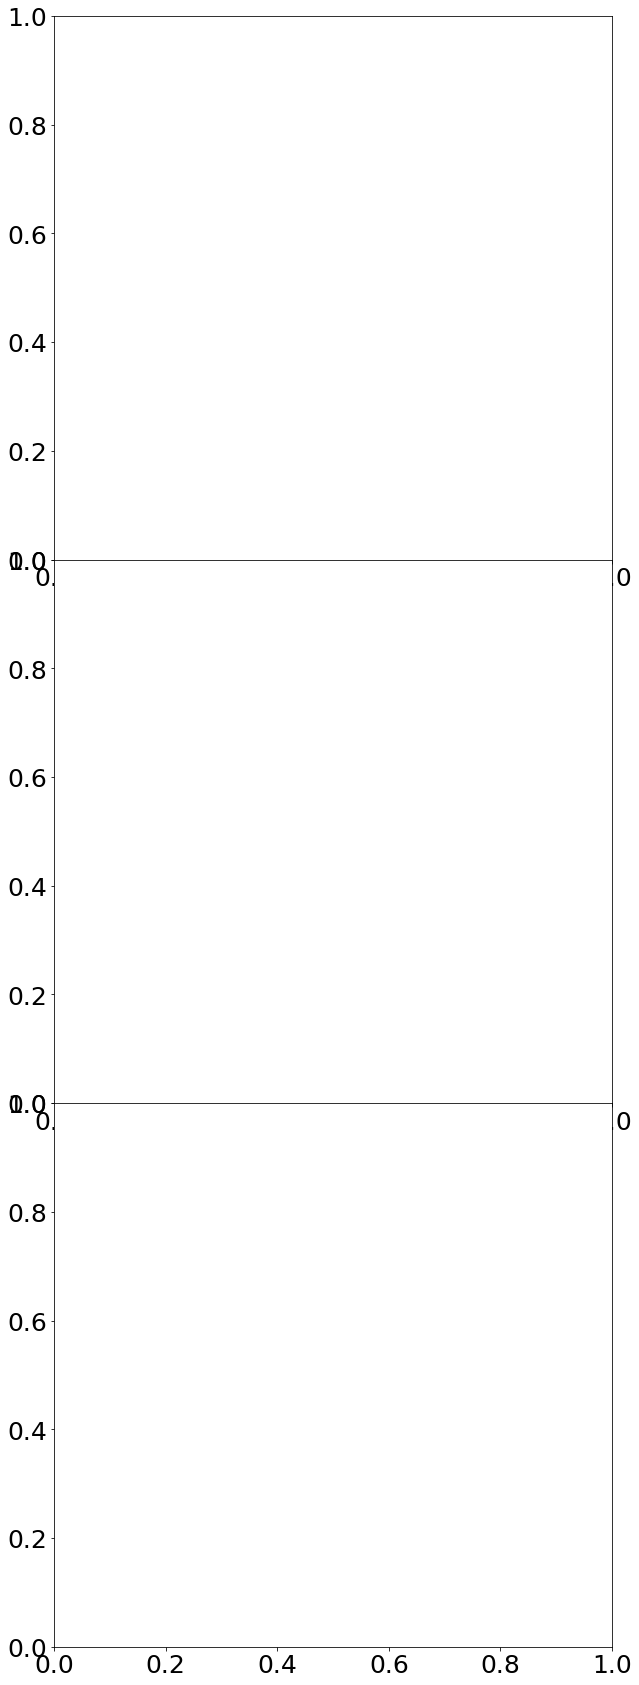

In [250]:
# figure and subplots

MpctoKpc =1000
x_start=40  #kpc: min impact parameter 


DM_Rad_fig_16, DM_Rad_axs = plt.subplots(3, 1,
                        gridspec_kw={'hspace': 0, 'wspace': .2},figsize=(10,30))

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

# plt.rc('axes', titlesize=30)     # fontsize of the axes title
# plt.rc('axes', labelsize=20)    # fontsize of the x and y labels



# First plot

# DM_Rad_axs[0].semilogx(np.linspace(0,extent,TH_DMvsR.shape[1]),TH_DMvsR[M_chosen[0],:]-mean_DM,'-', label= '2D tophat')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH_DMvsR_16.shape[1]),STH_DMvsR_16[M_chosen[1],:]-mean_DM,'-', label= '3D Tophat',lw=3,color= 'red')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire_DMvsR_16.shape[1]),fire_DMvsR_16[M_chosen[1],:]-mean_DM,'-', label= 'fire',lw=3,color='green')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW_DMvsR_16.shape[1]),NFW_DMvsR_16[M_chosen[1],:]-mean_DM,'-' ,label= 'NFW',lw=3,color='blue')


# Masks
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,STH_masks_16.shape[1]),STH_masks_16[M_chosen[1],:],'--', lw=2,color='red')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,fire_masks_16.shape[1]),fire_masks_16[M_chosen[1],:],'--',lw=2,color='green')
DM_Rad_axs[0].semilogx(MpctoKpc*np.linspace(0,extent,NFW_masks_16.shape[1]),NFW_masks_16[M_chosen[1],:],'--', lw=2,color='blue')


DM_Rad_axs[0].set_ylim([0, 60])
DM_Rad_axs[0].set_xlim([x_start, MpctoKpc*2])


# axis title
# DM_Rad_axs[0].set_title('Mass = %.1E' % Decimal(df[2][M_chosen[1]]),fontsize=14)
DM_Rad_axs[0].text(MpctoKpc*.1, 55, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[1]]),fontsize=20)


# Second plot

# DM_Rad_axs[1].semilogx(np.linspace(0,extent,TH_DMvsR.shape[1]),TH_DMvsR[M_chosen[2],:]-mean_DM,'-', label= '2D tophat',)
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH_DMvsR_16.shape[1]),STH_DMvsR_16[M_chosen[2],:]-mean_DM,'-', label= '3D tophat',lw=3,color='red')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire_DMvsR_16.shape[1]),fire_DMvsR_16[M_chosen[2],:]-mean_DM,'-' ,label= 'fire',lw=3,color='green')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW_DMvsR_16.shape[1]),NFW_DMvsR_16[M_chosen[2],:]-mean_DM,'-', label= 'NFW',lw=3,color='blue')

# Masks
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,STH_masks_16.shape[1]),STH_masks_16[M_chosen[2],:],'--', lw=2,color='red')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,fire_masks_16.shape[1]),fire_masks_16[M_chosen[2],:],'--',lw=2,color='green')
DM_Rad_axs[1].semilogx(MpctoKpc*np.linspace(0,extent,NFW_masks_16.shape[1]),NFW_masks_16[M_chosen[2],:],'--', lw=2,color='blue')

DM_Rad_axs[1].set_ylim(ymin=0,ymax=199)
DM_Rad_axs[1].set_xlim([x_start, MpctoKpc*2])


# DM_Rad_axs[1].set_title('Mass = %.1E' % Decimal(df[2][M_chosen[2]]),fontsize=14)
DM_Rad_axs[1].text(MpctoKpc*.1, 180, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[2]]),fontsize=20)



# Third plot


DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH_DMvsR_16.shape[1]),STH_DMvsR_16[M_chosen[3],:]-mean_DM,'-', label= '3D tophat',lw=3,color='red')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire_DMvsR_16.shape[1]),fire_DMvsR_16[M_chosen[3],:]-mean_DM,'-', label= 'Fire',lw=3,color='green')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW_DMvsR_16.shape[1]),NFW_DMvsR_16[M_chosen[3],:]-mean_DM, '-',label= 'NFW',lw=3,color='blue')


DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,STH_masks_16.shape[1]),STH_masks_16[M_chosen[3],:],'--', lw=2,color='red')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,fire_masks_16.shape[1]),fire_masks_16[M_chosen[3],:],'--',lw=2,color='green')
DM_Rad_axs[2].semilogx(MpctoKpc*np.linspace(0,extent,NFW_masks_16.shape[1]),NFW_masks_16[M_chosen[3],:], '--',lw=2,color='blue')




DM_Rad_axs[2].set_ylim(ymin=0,ymax=999)
DM_Rad_axs[2].set_xlim([x_start, MpctoKpc*2])

# DM_Rad_axs[2].set_title('Mass = %.1E' % Decimal(df[2][M_chosen[3]]),fontsize=14)
DM_Rad_axs[2].text(MpctoKpc*.1, 925, 'Mass = %.1E $M_\odot$' % Decimal(df[2][M_chosen[3]]),fontsize=20)



# ticks

# ax.xaxis.grid(True, which='minor')
# DM_Rad_axs[0].xaxis.grid(axis='x', which='minor', bottom=True)

# DM_Rad_axs[0].tick_params(axis='x', which='minor', bottom=True)
# DM_Rad_axs[1].tick_params(axis='x', which='minor', bottom=True)

DM_Rad_axs[0].tick_params(axis='x', which='minor')

# legend

DM_Rad_axs[0].legend(loc='upper right',prop={'size':18})
# DM_Rad_axs[0].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[1].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
# DM_Rad_axs[2].set_ylabel('DM - <DM> [pc $cm^{-3}$]',fontsize=30)
DM_Rad_axs[2].set_xlabel('Impact Parameter [kpc]',fontsize=30)




DM_Rad_fig_16.savefig('DMvsRad_profiles_16.pdf',bbox_inches='tight')

# Rough work

## Rough work for STH+ NFW

In [139]:
# Resolution: choose between 256 and 512 grid
den_grid_size = 256


# User provides a redshift array
# RS_array = [0] # For a single box, we only use the redshift 0 box
RS_array = [avgZ(1),avgZ(2),avgZ(3),avgZ(4),avgZ(5)]


# Profile used for subtracting halos from the density field
subtraction_halo_profile = 'NFW'



In [114]:
# Create density field for the chosen resolution

# all_den_fields_512 = extract_all_den_fields(RS_array,den_grid_size)
# all_den_fields_256_RS = extract_all_den_fields(RS_array,den_grid_size)

In [140]:
# Mass range of halos
min_mass=10**10
max_mass=10**14.5
log_bins=30


addition_halo_profile = '2RVSTH_and_NFW' 
scaling_radius=1

bin1_STH1_256 = hist_profile(all_den_fields_256_RS,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


In [94]:
all_bins= bin1_STH1_256[1][0,:,:]#+bin2_NFW1_256[1][0,:,:]

def histArray_with_range(arr,nbin,Ncel,DMmin,DMmax):
    hist, bins = np.histogram(arr,bins=nbin,range=(DMmin, DMmax))
    dv=bins[1]-bins[0]
    hist=(hist)/(dv*Ncel**2)
    cumulative = (np.cumsum(hist)*dv)
    center = (bins[:-1] + bins[1:]) / 2
    return center, hist, cumulative[-1]


STH_NFW = histArray_with_range(all_bins,500,1024,0,400)
STH1R = histArray_with_range(STH1_256[1],500,1024,0,400)
STH2R = histArray_with_range(STH1_2_256[1],500,1024,0,400)
NFW = histArray_with_range(NFW1_256[1],500,1024,0,400)
fire = histArray_with_range(fire1_256[1],500,1024,0,400)

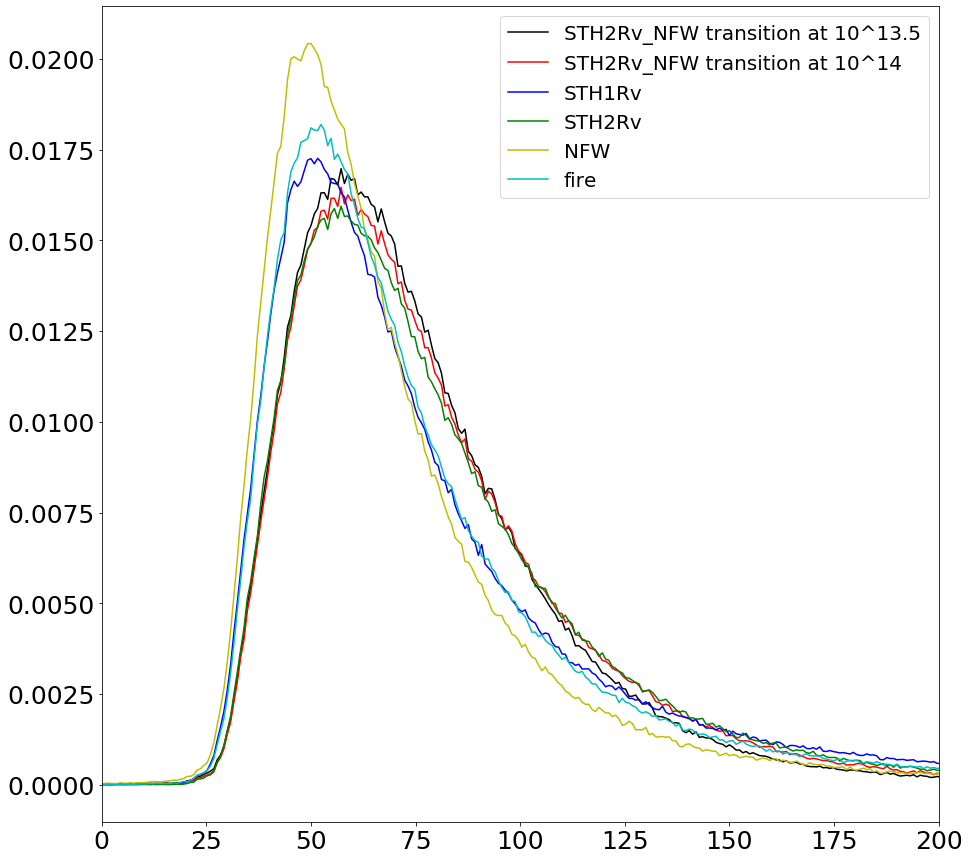

In [110]:
plt.rcParams["figure.figsize"] = (15,15)
# plt.plot(STH_NFW[0],STH_NFW[1],'.',label='STH2Rv_NFW')
plt.plot(STH4_NFW_hist[0],STH4_NFW_hist[1],'k',label='STH2Rv_NFW transition at 10^13.5')
plt.plot(STH4_NFW_14_hist[0],STH4_NFW_14_hist[1],'r',label='STH2Rv_NFW transition at 10^14')
plt.plot(STH1R[0],STH1R[1],'b',label='STH1Rv')
plt.plot(STH2R[0],STH2R[1],'g',label='STH2Rv')
plt.plot(NFW[0],NFW[1],'y',label='NFW')
plt.plot(fire[0],fire[1],'c',label='fire')


plt.legend(loc='upper right')
plt.xlim(0,200)
plt.savefig('NFW_Tophat_combined.pdf',bbox_inches='tight')

In [89]:
# This one is where we transition at 10**13.5

# Mass range of halos
min_mass=10**10
max_mass=10**14.5
log_bins=30


addition_halo_profile = '2RVSTH_and_NFW' 
scaling_radius=1

STH4_NFW_256 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)




/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


In [96]:
STH4_NFW_hist= histArray_with_range(STH4_NFW_256[1][0,:,:],500,1024,0,400)

In [105]:
# This one is where we transition at 10**14

# Mass range of halos
min_mass=10**10
max_mass=10**14.5
log_bins=30


addition_halo_profile = '2RVSTH_and_NFW' 
scaling_radius=1

STH4_NFW_14 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)

STH4_NFW_14_hist= histArray_with_range(STH4_NFW_14[1][0,:,:],500,1024,0,400)


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


In [141]:
# Compare things at RS =.5 for each profile
STH_NFW_RShalf = histArray_with_range(sum(bin1_STH1_256[6][0:5,:,:]),100,1024,0,1000)
STH_RShalf = histArray_with_range(sum(STH1_256_RS_array[6][0:5,:,:]),100,1024,0,1000)
STH_2_RShalf = histArray_with_range(sum(STH1_2_256_RS_array[6][0:5,:,:]),100,1024,0,1000)
NFW_RShalf = histArray_with_range(sum(NFW1_256_RS_array[6][0:5,:,:]),100,1024,0,1000)
fire_RShalf = histArray_with_range(sum(fire1_256_RS_array[6][0:5,:,:]),100,1024,0,1000)



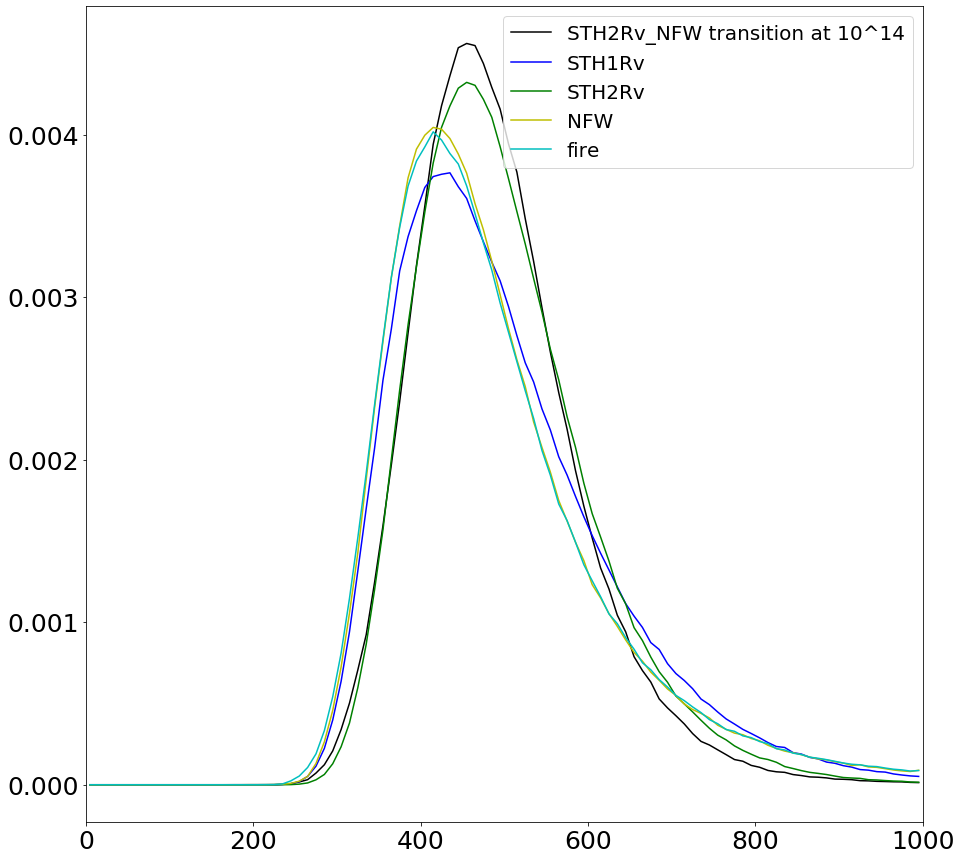

In [158]:
plt.rcParams["figure.figsize"] = (15,15)
# plt.plot(STH_NFW[0],STH_NFW[1],'.',label='STH2Rv_NFW')
plt.plot(STH_NFW_RShalf[0],STH_NFW_RShalf[1],'k',label='STH2Rv_NFW transition at 10^14')
plt.plot(STH_RShalf[0],STH_RShalf[1],'b',label='STH1Rv')
plt.plot(STH_2_RShalf[0],STH_2_RShalf[1],'g',label='STH2Rv')
plt.plot(NFW_RShalf[0],NFW_RShalf[1],'y',label='NFW')
plt.plot(fire_RShalf[0],fire_RShalf[1],'c',label='fire')


plt.legend(loc='upper right')
plt.xlim(0,1000)
plt.savefig('NFW_Tophat_combined_RS.pdf',bbox_inches='tight')

# Testing precipitation model


### When testing, from the files below, only run the ones that you change

In [3]:
# This chapter contains contains all cosmological parameters, as well as other basic functions 
%run FRBProject-Chap1-ParametersAndFunctions.ipynb

# These chapters extracts data from simulation files 
%run FRBProject-Chap2-ExtractData-256Grid.ipynb
%run FRBProject-Chap3-ExtractData-Halos.ipynb
#%run FRBProject-Chap2-ExtractData-512Grid.ipynb


# This chapter is the core of the method developed in this project
%run FRBProject-Chap4-Convolution.ipynb


# This chapter contains functions for creating dispersion measure profiles of halos
%run FRBProject-Chap5-DMProfiles.ipynb


# This chapter contains functions to stack boxes to project a sightline to higher redshifts
%run FRBProject-Chap6-Stacking.ipynb



In [15]:
# Create a data frame of halos
df= create_halo_array_for_convolution(extract_halos(0),min_mass,max_mass,log_bins)

In [12]:
# Resolution: choose between 256 and 512 grid
den_grid_size = 256



# User provides a redshift array
RS_array_1 = [0] # For a single box, we only use the redshift 0 box



# Profile used for subtracting halos from the density field
subtraction_halo_profile = 'NFW'


# Mass range of halos
min_mass=10**10
max_mass=10**14.5
log_bins=30


In [13]:
# Create density field for the chosen resolution

# all_den_fields_512 = extract_all_den_fields(RS_array,den_grid_size)
all_den_fields_256 = extract_all_den_fields(RS_array_1,den_grid_size)

In [14]:
### Tophat 256 fieild


addition_halo_profile = 'precipitation'

scaling_radius = 1 

# p1 = hist_profile(all_den_fields_256,den_grid_size,RS_array_1,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)


# addition_halo_profile = 'fire'

# fire1 = hist_profile(all_den_fields_256,den_grid_size,RS_array,min_mass,max_mass,
#                                        log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,1)




p8 = hist_profile(all_den_fields_256,den_grid_size,RS_array_1,min_mass,max_mass,
                                       log_bins,subtraction_halo_profile,addition_halo_profile,scaling_radius,8)



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing imports until
/epyc/opt/anacon

In [43]:
saveArray('p8',p8)

In [17]:
p8_hist = histArray(p8[6][0,:,:],1000,1024*8)

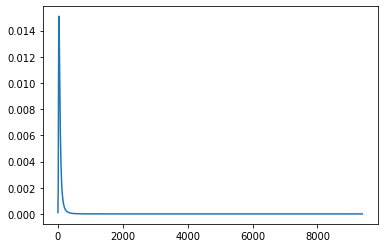

In [19]:
plt.plot(p8_hist[0],p8_hist[1])

# Rough work

## Mask analysis

In [16]:
# Specify resolution
resolution=1
grid_size = resolution*1024
# trim_dim=int((10*resolution)/2+1)  # Need +1 to match the dimensions of the mask grids
# trim_dim=int((10*resolution)+1)  # Need +1 to match the dimensions of the mask grids

trim_dim=int((20*resolution))

# Radial extent of the plots in Mpc
extent = (L/grid_size)*(trim_dim)



# # STH_DMvsR=DM_vs_radius(STH8_256[1][0,:,:],df,trim_dim, mass_bins, halos_per_mass_bin)
# STH1_rad=DM_vs_radius(STH1_256[1][0,:,:],df[0],trim_dim, df[2], df[1])


p1_rad=DM_vs_radius(p1[1][0,:,:],df[0],trim_dim, df[2], df[1])
p1_masks = profile_of_masks(p1[2][0,:,:,:])




# fire1_rad=DM_vs_radius(fire1[1][0,:,:],df[0],trim_dim, df[2], df[1])
# fire1_masks = profile_of_masks(fire1[2][0,:,:,:])



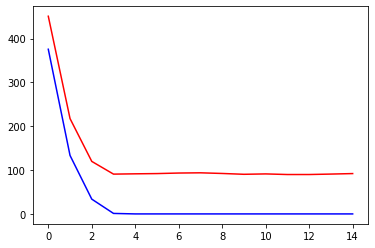

In [17]:
plt.plot(p1_rad[0][22,:],'r')
plt.plot(p1_masks[22,:],'b')


117.62361459419937

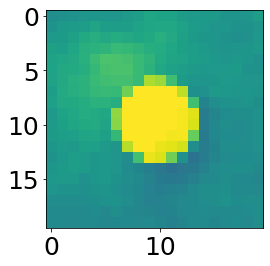

In [1069]:
plt.imshow(p1_rad[1][28,:,:],vmin=0,vmax=200)
np.mean(p1_rad[1][28,:,:])

42.38448343689618

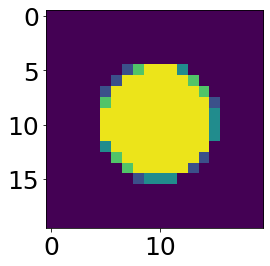

In [1070]:
plt.imshow(p1[2][0,28,:,:],vmin=0,vmax=200)
np.mean(p1[2][0,28,:,:])

In [28]:
# Specify resolution
resolution=8
grid_size = resolution*1024
# trim_dim=int((10*resolution)/2+1)  # Need +1 to match the dimensions of the mask grids
# trim_dim=int((10*resolution)+1)  # Need +1 to match the dimensions of the mask grids

trim_dim=int((20*resolution))

# Radial extent of the plots in Mpc
extent = (L/grid_size)*(trim_dim)



# # STH_DMvsR=DM_vs_radius(STH8_256[1][0,:,:],df,trim_dim, mass_bins, halos_per_mass_bin)
# STH1_rad=DM_vs_radius(STH1_256[1][0,:,:],df[0],trim_dim, df[2], df[1])


p8_rad=DM_vs_radius(p8[1][0,:,:],df[0],trim_dim, df[2], df[1])
p8_masks = profile_of_masks(p8[2][0,:,:,:])
 



# fire1_rad=DM_vs_radius(fire1[1][0,:,:],df[0],trim_dim, df[2], df[1])
# fire1_masks = profile_of_masks(fire1[2][0,:,:,:])



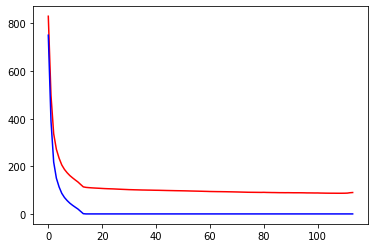

In [32]:
plt.plot(p8_rad[0][18,:],'r')
plt.plot(p8_masks[18,:],'b')


In [45]:
orig_den_256.shape

(256, 256)

In [46]:
orig_den_256

array([[ 88.77668841,  94.37661312,  75.42460666, ...,  61.82413765,
         59.3357733 ,  66.69326014],
       [130.52619285, 136.03045599, 100.38668789, ...,  67.25481509,
         71.09717759,  91.92203866],
       [138.01283716, 137.11351156,  98.9542461 , ...,  70.43247067,
         81.58563115, 104.92650771],
       ...,
       [ 50.85476453,  57.92748349,  52.73309721, ...,  67.14563643,
         49.78011631,  43.73973654],
       [ 47.3209417 ,  52.27392706,  49.77782148, ...,  60.95803673,
         49.17459151,  43.05379878],
       [ 55.62443852,  59.47432127,  53.37049114, ...,  55.94238535,
         50.09167932,  48.09016277]])

In [49]:
orig2=np.transpose(orig_den_256, axes=0)


ValueError: axes don't match array